In [135]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvi
import os
sc.set_figure_params(figsize=(4, 4))


num_of_clusters = 4

ToolName = 'scvi-tools' 
DatasetName = 'zheng-4'
Data_path = '../../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../../results/{}/{}/'.format(DatasetName, ToolName)


if not os.path.exists(save_path):
    os.makedirs(save_path)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Loading and preparing data

In [136]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)
adata

AnnData object with n_obs × n_vars = 3959 × 12871
    var: 'gene_ids'

/var/folders/13/j6b4qnl1339416k0hpyswb8r0000gn/T/ipykernel_42948/3980758076.py:7: RuntimeWarning: divide by zero encountered in log
  sorted_array = [np.log(-i) for i in variances.T][:3000]


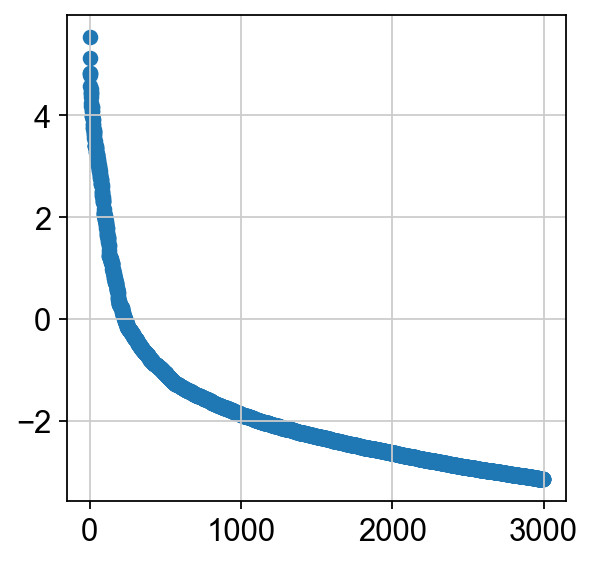

In [137]:
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
variances = np.sort(-np.var(matrix, axis=0))
sorted_array = [np.log(-i) for i in variances.T][:3000]
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)

In [138]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

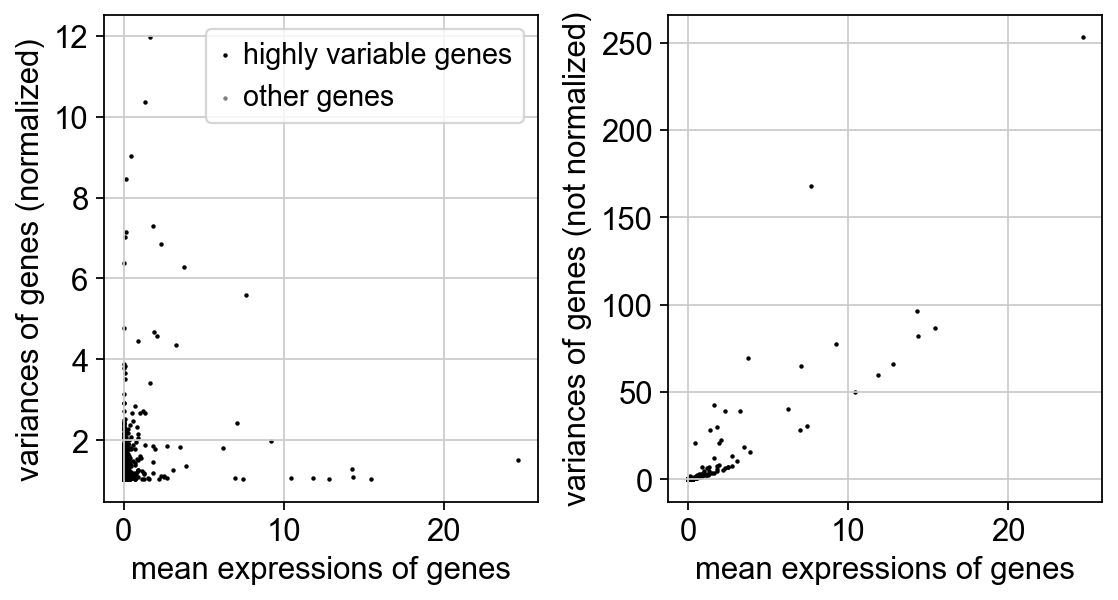

In [139]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)

In [140]:
sc.pp.scale(adata, max_value=10)

In [141]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [142]:
if os.path.exists('./models/{}/'.format(DatasetName)):
    model = scvi.model.SCVI.load('./models/{}/'.format(DatasetName), adata=adata, use_gpu=True)
else:
    model = scvi.model.SCVI(adata)
    model.train(use_gpu=False)
    model.save('./models/{}/'.format(DatasetName))
    
model

INFO     File ./models/zheng-4/model.pt already downloaded                                                         


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

We can see an overview of the model by printing it.

## Obtaining model outputs

In [143]:
latent = model.get_latent_representation()

In [144]:
adata.obsm["X_scVI"] = latent
adata_subset = adata

In [145]:
latent_subset = model.get_latent_representation(adata_subset)

In [146]:
denoised = model.get_normalized_expression(adata_subset)
denoised.iloc[:5, :5]

,KLHL17,HES4,ISG15,AGRN,TTLL10
ACGGAGGACCGAAT,6.307354e-07,5.868972e-07,0.000335,1.450795e-07,0.000013
GCAGCGTGCCGAAT,2.855156e-07,1.109966e-06,0.000140,7.894665e-08,0.000020
GATTTAGAGTGTAC,1.382887e-08,7.581227e-08,0.000157,7.544056e-08,0.000001
TCAGTGGAGTTCAG,1.165009e-08,5.469135e-07,0.000185,2.418539e-06,0.000002
GCCTCATGCGGGAA,5.450252e-06,9.887983e-08,0.000365,2.721845e-09,0.000008


Let's store the normalized values back in the anndata.

In [147]:
adata.layers["scvi_normalized"] = model.get_normalized_expression()

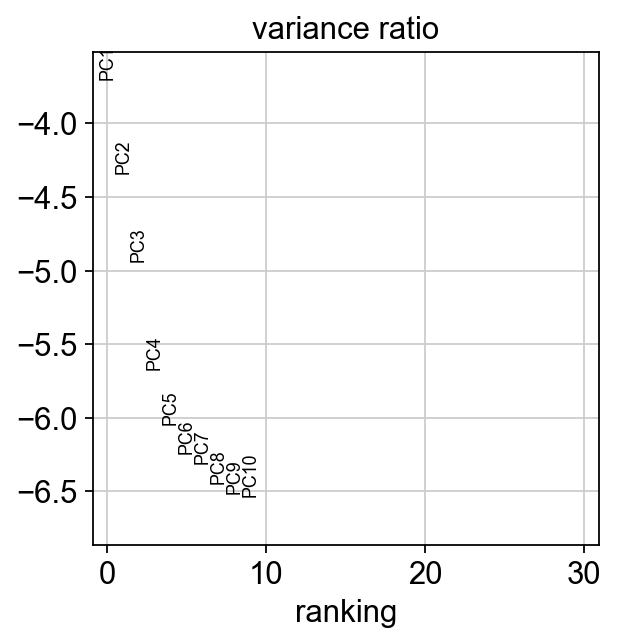

In [148]:
# run PCA then generate UMAP plots
sc.tl.pca(adata, svd_solver="arpack", n_comps=10, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

In [149]:
sc.pp.neighbors(adata, n_pcs=10, n_neighbors=20, use_rep="X_scVI")

In [150]:
# neighbors were already computed using scVI

res = 0.01
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
while not (adata.obs.leiden_scVI.values.categories.values).shape == (num_of_clusters,) or res == 1.0:
    res += 0.01
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
print(adata)

AnnData object with n_obs × n_vars = 3959 × 3000
    obs: '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'leiden'
    obsm: 'X_scVI', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'


/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


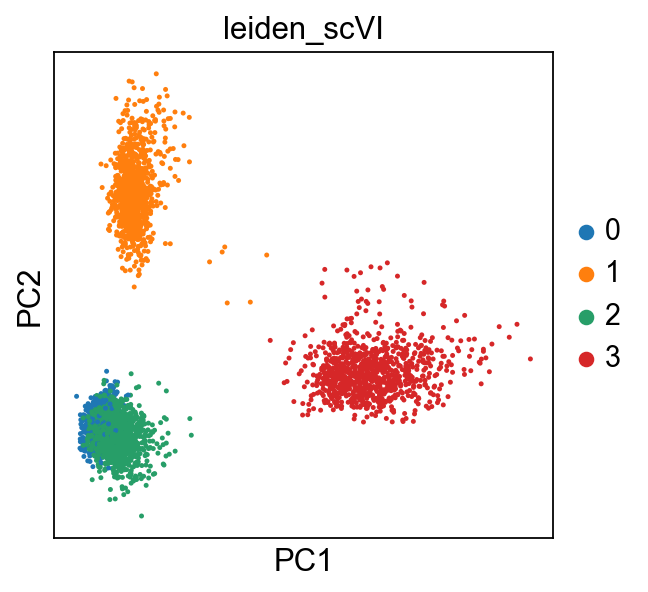

In [151]:
sc.pl.pca(
    adata,
    color=["leiden_scVI"],
    size=20,
)

In [152]:
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon') # method='wilcoxon' method='logreg'

In [131]:

df = pd.DataFrame(adata.obs['leiden_scVI'])

labels = df.rename(columns={'leiden_scVI': 'cluster'})
# rename index as cell
labels.index.names = ['cell']

labels['cluster'] = labels['cluster'].astype(int) + 1


labels.to_csv(save_path+'clustering_labels.csv')

In [154]:
number_of_genes = 50

de_df = model.differential_expression(
    groupby="leiden_scVI",
)
markers = {}
cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cell_type_df = de_df.loc[de_df.group1 == c]
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 1]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]
    markers[c] = cell_type_df.sort_values('lfc_mean', ascending=False).index.tolist()[:number_of_genes]
    
df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(num_of_clusters):
    to_add = [ [markers[str(i)][j], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] += 1
df['rank'] += 1
df.to_csv(save_path+'markers.csv', index=False)


DE...: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
